#  Importing packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

### Importing Dataset 

In [3]:
AAPL = pd.read_csv("Pre_Processed_AAPL.csv")

### Creating and normalizing dataset

In [5]:
def Dataset(Data, Date):
  Train_Data = Data['Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Creating model 

In [6]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [7]:
model = Model() # Creating object of the model

In [8]:
model.summary() # Defining the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 200)            161600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
Total params: 548,005
Trainable params: 548,005
Non-trainable params: 0
__________________________________________________

### Custom Learning Rate

In [9]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

### Plotting the learning rate  

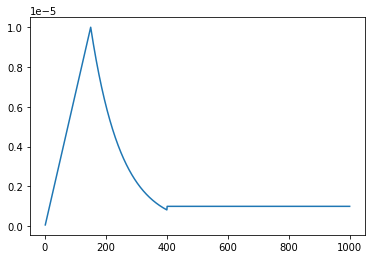

In [11]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [13]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler) # Defining learning rate scheduler

In [14]:
AAPL.head() # Checking the data

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,27.85,27.86,26.84,27.33,24.86,212818400.0
1,2015-01-05,27.07,27.16,26.35,26.56,24.16,257142000.0
2,2015-01-06,26.64,26.86,26.16,26.57,24.16,263188400.0
3,2015-01-07,26.80,27.05,26.67,26.94,24.50,160423600.0
4,2015-01-08,27.31,28.04,27.17,27.97,25.44,237458000.0


In [15]:
AAPL.info() # Defining the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


### Cleaning data

In [16]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

In [17]:
#Spliting  the Data into Training and Test set Training Period: 2015-01-02 - 2020-09-30

In [18]:
AAPL_Date = '2020-10-01'
AAPL_Train_X, AAPL_Train_Y, AAPL_Test_X, AAPL_Test_Y = Dataset(AAPL, AAPL_Date)

### Fitting the model

In [19]:
AAPL_Model = Model()

In [20]:
AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError()) # Compiling the model

In [21]:
AAPL_hist = AAPL_Model.fit(AAPL_Train_X, AAPL_Train_Y, epochs = 1000, validation_data = (AAPL_Test_X, AAPL_Test_Y), callbacks=[callback])

Epoch 1/1000
9/9 [==============================] - 3s 76ms/step - loss: 2279.6262 - root_mean_squared_error: 47.7312 - val_loss: 15431.9766 - val_root_mean_squared_error: 124.2255
Epoch 2/1000
9/9 [==============================] - 0s 14ms/step - loss: 2612.8097 - root_mean_squared_error: 51.0263 - val_loss: 15431.5361 - val_root_mean_squared_error: 124.2237
Epoch 3/1000
9/9 [==============================] - 0s 14ms/step - loss: 2454.8427 - root_mean_squared_error: 49.5398 - val_loss: 15430.6660 - val_root_mean_squared_error: 124.2202
Epoch 4/1000
9/9 [==============================] - 0s 15ms/step - loss: 2262.5491 - root_mean_squared_error: 47.5336 - val_loss: 15429.4209 - val_root_mean_squared_error: 124.2152
Epoch 5/1000
9/9 [==============================] - 0s 16ms/step - loss: 2535.8676 - root_mean_squared_error: 50.3191 - val_loss: 15427.6328 - val_root_mean_squared_error: 124.2080
Epoch 6/1000
9/9 [==============================] - 0s 15ms/step - loss: 2323.4935 - root_mean_

9/9 [==============================] - 0s 16ms/step - loss: 2260.3906 - root_mean_squared_error: 47.5366 - val_loss: 14683.6875 - val_root_mean_squared_error: 121.1763
Epoch 47/1000
9/9 [==============================] - 0s 16ms/step - loss: 2240.1527 - root_mean_squared_error: 47.3264 - val_loss: 14646.5195 - val_root_mean_squared_error: 121.0228
Epoch 48/1000
9/9 [==============================] - 0s 15ms/step - loss: 2256.6862 - root_mean_squared_error: 47.4598 - val_loss: 14605.6924 - val_root_mean_squared_error: 120.8540
Epoch 49/1000
9/9 [==============================] - 0s 15ms/step - loss: 2195.5494 - root_mean_squared_error: 46.8266 - val_loss: 14564.3516 - val_root_mean_squared_error: 120.6829
Epoch 50/1000
9/9 [==============================] - 0s 16ms/step - loss: 2461.5818 - root_mean_squared_error: 49.5772 - val_loss: 14518.3799 - val_root_mean_squared_error: 120.4922
Epoch 51/1000
9/9 [==============================] - 0s 15ms/step - loss: 2242.2382 - root_mean_squared_

9/9 [==============================] - 0s 16ms/step - loss: 940.0234 - root_mean_squared_error: 30.6566 - val_loss: 4831.4385 - val_root_mean_squared_error: 69.5085
Epoch 92/1000
9/9 [==============================] - 0s 16ms/step - loss: 965.2458 - root_mean_squared_error: 31.0486 - val_loss: 4474.6646 - val_root_mean_squared_error: 66.8929
Epoch 93/1000
9/9 [==============================] - 0s 16ms/step - loss: 825.2548 - root_mean_squared_error: 28.7230 - val_loss: 4215.7061 - val_root_mean_squared_error: 64.9285
Epoch 94/1000
9/9 [==============================] - 0s 35ms/step - loss: 777.3146 - root_mean_squared_error: 27.8684 - val_loss: 4033.4548 - val_root_mean_squared_error: 63.5095
Epoch 95/1000
9/9 [==============================] - 0s 18ms/step - loss: 692.8779 - root_mean_squared_error: 26.3205 - val_loss: 3924.7158 - val_root_mean_squared_error: 62.6476
Epoch 96/1000
9/9 [==============================] - 0s 17ms/step - loss: 678.7423 - root_mean_squared_error: 26.0504 -

9/9 [==============================] - 0s 16ms/step - loss: 10.5654 - root_mean_squared_error: 3.2433 - val_loss: 34.5772 - val_root_mean_squared_error: 5.8802
Epoch 138/1000
9/9 [==============================] - 0s 18ms/step - loss: 8.7348 - root_mean_squared_error: 2.9334 - val_loss: 33.2476 - val_root_mean_squared_error: 5.7661
Epoch 139/1000
9/9 [==============================] - 0s 15ms/step - loss: 8.6587 - root_mean_squared_error: 2.9049 - val_loss: 31.9543 - val_root_mean_squared_error: 5.6528
Epoch 140/1000
9/9 [==============================] - 0s 16ms/step - loss: 7.9271 - root_mean_squared_error: 2.7902 - val_loss: 31.1447 - val_root_mean_squared_error: 5.5807
Epoch 141/1000
9/9 [==============================] - 0s 16ms/step - loss: 7.7676 - root_mean_squared_error: 2.7797 - val_loss: 30.3859 - val_root_mean_squared_error: 5.5123
Epoch 142/1000
9/9 [==============================] - 0s 15ms/step - loss: 7.5999 - root_mean_squared_error: 2.7467 - val_loss: 29.8651 - val_ro

9/9 [==============================] - 0s 17ms/step - loss: 5.2578 - root_mean_squared_error: 2.2799 - val_loss: 29.0125 - val_root_mean_squared_error: 5.3863
Epoch 185/1000
9/9 [==============================] - 0s 17ms/step - loss: 7.7271 - root_mean_squared_error: 2.7669 - val_loss: 28.6439 - val_root_mean_squared_error: 5.3520
Epoch 186/1000
9/9 [==============================] - 0s 17ms/step - loss: 6.6670 - root_mean_squared_error: 2.5792 - val_loss: 29.4811 - val_root_mean_squared_error: 5.4297
Epoch 187/1000
9/9 [==============================] - 0s 17ms/step - loss: 6.7077 - root_mean_squared_error: 2.5788 - val_loss: 29.6481 - val_root_mean_squared_error: 5.4450
Epoch 188/1000
9/9 [==============================] - 0s 32ms/step - loss: 7.6335 - root_mean_squared_error: 2.7571 - val_loss: 28.8969 - val_root_mean_squared_error: 5.3756
Epoch 189/1000
9/9 [==============================] - 0s 24ms/step - loss: 5.0431 - root_mean_squared_error: 2.2190 - val_loss: 28.8129 - val_roo

9/9 [==============================] - 0s 39ms/step - loss: 7.0203 - root_mean_squared_error: 2.6262 - val_loss: 28.3539 - val_root_mean_squared_error: 5.3248
Epoch 232/1000
9/9 [==============================] - 0s 18ms/step - loss: 6.8714 - root_mean_squared_error: 2.6121 - val_loss: 28.8350 - val_root_mean_squared_error: 5.3698
Epoch 233/1000
9/9 [==============================] - 0s 17ms/step - loss: 8.1459 - root_mean_squared_error: 2.8439 - val_loss: 28.9315 - val_root_mean_squared_error: 5.3788
Epoch 234/1000
9/9 [==============================] - 0s 17ms/step - loss: 5.2178 - root_mean_squared_error: 2.2715 - val_loss: 28.9685 - val_root_mean_squared_error: 5.3822
Epoch 235/1000
9/9 [==============================] - 0s 17ms/step - loss: 7.0679 - root_mean_squared_error: 2.6315 - val_loss: 28.8802 - val_root_mean_squared_error: 5.3740
Epoch 236/1000
9/9 [==============================] - 0s 41ms/step - loss: 6.8886 - root_mean_squared_error: 2.6180 - val_loss: 29.2150 - val_roo

9/9 [==============================] - 0s 32ms/step - loss: 7.9095 - root_mean_squared_error: 2.8016 - val_loss: 27.3102 - val_root_mean_squared_error: 5.2259
Epoch 279/1000
9/9 [==============================] - 0s 15ms/step - loss: 6.1639 - root_mean_squared_error: 2.4804 - val_loss: 27.9104 - val_root_mean_squared_error: 5.2830
Epoch 280/1000
9/9 [==============================] - 0s 37ms/step - loss: 5.8175 - root_mean_squared_error: 2.3961 - val_loss: 28.1783 - val_root_mean_squared_error: 5.3083
Epoch 281/1000
9/9 [==============================] - 0s 33ms/step - loss: 6.8642 - root_mean_squared_error: 2.6108 - val_loss: 28.1282 - val_root_mean_squared_error: 5.3036
Epoch 282/1000
9/9 [==============================] - 0s 18ms/step - loss: 6.4953 - root_mean_squared_error: 2.5450 - val_loss: 27.3844 - val_root_mean_squared_error: 5.2330
Epoch 283/1000
9/9 [==============================] - 0s 14ms/step - loss: 6.1937 - root_mean_squared_error: 2.4816 - val_loss: 27.6272 - val_roo

9/9 [==============================] - 0s 21ms/step - loss: 6.2904 - root_mean_squared_error: 2.5031 - val_loss: 26.9134 - val_root_mean_squared_error: 5.1878
Epoch 326/1000
9/9 [==============================] - 0s 15ms/step - loss: 7.0548 - root_mean_squared_error: 2.6275 - val_loss: 27.2544 - val_root_mean_squared_error: 5.2206
Epoch 327/1000
9/9 [==============================] - 0s 15ms/step - loss: 5.4028 - root_mean_squared_error: 2.2875 - val_loss: 26.9481 - val_root_mean_squared_error: 5.1912
Epoch 328/1000
9/9 [==============================] - 0s 15ms/step - loss: 6.2024 - root_mean_squared_error: 2.4869 - val_loss: 26.6057 - val_root_mean_squared_error: 5.1581
Epoch 329/1000
9/9 [==============================] - 0s 16ms/step - loss: 7.7145 - root_mean_squared_error: 2.7611 - val_loss: 26.8623 - val_root_mean_squared_error: 5.1829
Epoch 330/1000
9/9 [==============================] - 0s 15ms/step - loss: 6.1214 - root_mean_squared_error: 2.4576 - val_loss: 26.7913 - val_roo

9/9 [==============================] - 0s 15ms/step - loss: 4.8150 - root_mean_squared_error: 2.1862 - val_loss: 26.3388 - val_root_mean_squared_error: 5.1321
Epoch 373/1000
9/9 [==============================] - 0s 15ms/step - loss: 5.1671 - root_mean_squared_error: 2.2533 - val_loss: 26.4494 - val_root_mean_squared_error: 5.1429
Epoch 374/1000
9/9 [==============================] - 0s 28ms/step - loss: 4.8266 - root_mean_squared_error: 2.1718 - val_loss: 26.6048 - val_root_mean_squared_error: 5.1580
Epoch 375/1000
9/9 [==============================] - 0s 18ms/step - loss: 6.3397 - root_mean_squared_error: 2.5137 - val_loss: 26.1930 - val_root_mean_squared_error: 5.1179
Epoch 376/1000
9/9 [==============================] - 0s 20ms/step - loss: 6.8645 - root_mean_squared_error: 2.6015 - val_loss: 26.0243 - val_root_mean_squared_error: 5.1014
Epoch 377/1000
9/9 [==============================] - 0s 35ms/step - loss: 6.0690 - root_mean_squared_error: 2.4501 - val_loss: 26.3012 - val_roo

9/9 [==============================] - 0s 16ms/step - loss: 6.5957 - root_mean_squared_error: 2.5620 - val_loss: 25.8277 - val_root_mean_squared_error: 5.0821
Epoch 420/1000
9/9 [==============================] - 0s 16ms/step - loss: 7.3100 - root_mean_squared_error: 2.6905 - val_loss: 25.6513 - val_root_mean_squared_error: 5.0647
Epoch 421/1000
9/9 [==============================] - 0s 14ms/step - loss: 6.9336 - root_mean_squared_error: 2.6288 - val_loss: 25.5843 - val_root_mean_squared_error: 5.0581
Epoch 422/1000
9/9 [==============================] - 0s 22ms/step - loss: 7.8618 - root_mean_squared_error: 2.7609 - val_loss: 25.6272 - val_root_mean_squared_error: 5.0623
Epoch 423/1000
9/9 [==============================] - 0s 20ms/step - loss: 6.2812 - root_mean_squared_error: 2.5026 - val_loss: 25.6951 - val_root_mean_squared_error: 5.0690
Epoch 424/1000
9/9 [==============================] - 0s 17ms/step - loss: 4.9543 - root_mean_squared_error: 2.2156 - val_loss: 25.7439 - val_roo

9/9 [==============================] - 0s 14ms/step - loss: 5.7965 - root_mean_squared_error: 2.3884 - val_loss: 25.2367 - val_root_mean_squared_error: 5.0236
Epoch 467/1000
9/9 [==============================] - 0s 14ms/step - loss: 7.8244 - root_mean_squared_error: 2.7753 - val_loss: 25.0703 - val_root_mean_squared_error: 5.0070
Epoch 468/1000
9/9 [==============================] - 0s 15ms/step - loss: 7.7030 - root_mean_squared_error: 2.7514 - val_loss: 25.1933 - val_root_mean_squared_error: 5.0193
Epoch 469/1000
9/9 [==============================] - 0s 14ms/step - loss: 5.8189 - root_mean_squared_error: 2.4046 - val_loss: 25.0637 - val_root_mean_squared_error: 5.0064
Epoch 470/1000
9/9 [==============================] - 0s 38ms/step - loss: 5.9228 - root_mean_squared_error: 2.4261 - val_loss: 25.1100 - val_root_mean_squared_error: 5.0110
Epoch 471/1000
9/9 [==============================] - 0s 15ms/step - loss: 4.1761 - root_mean_squared_error: 2.0273 - val_loss: 25.1811 - val_roo

9/9 [==============================] - 0s 17ms/step - loss: 6.7812 - root_mean_squared_error: 2.5928 - val_loss: 24.3937 - val_root_mean_squared_error: 4.9390
Epoch 514/1000
9/9 [==============================] - 0s 20ms/step - loss: 5.3934 - root_mean_squared_error: 2.3097 - val_loss: 24.7129 - val_root_mean_squared_error: 4.9712
Epoch 515/1000
9/9 [==============================] - 0s 20ms/step - loss: 5.9312 - root_mean_squared_error: 2.4312 - val_loss: 24.5129 - val_root_mean_squared_error: 4.9510
Epoch 516/1000
9/9 [==============================] - 0s 17ms/step - loss: 6.8570 - root_mean_squared_error: 2.6076 - val_loss: 24.4288 - val_root_mean_squared_error: 4.9425
Epoch 517/1000
9/9 [==============================] - 0s 16ms/step - loss: 5.2231 - root_mean_squared_error: 2.2830 - val_loss: 24.5875 - val_root_mean_squared_error: 4.9586
Epoch 518/1000
9/9 [==============================] - 0s 16ms/step - loss: 5.8565 - root_mean_squared_error: 2.4162 - val_loss: 24.5798 - val_roo

9/9 [==============================] - 0s 14ms/step - loss: 5.4062 - root_mean_squared_error: 2.3131 - val_loss: 24.2376 - val_root_mean_squared_error: 4.9232
Epoch 561/1000
9/9 [==============================] - 0s 14ms/step - loss: 6.3258 - root_mean_squared_error: 2.5123 - val_loss: 24.0148 - val_root_mean_squared_error: 4.9005
Epoch 562/1000
9/9 [==============================] - 0s 15ms/step - loss: 6.9859 - root_mean_squared_error: 2.6247 - val_loss: 23.9547 - val_root_mean_squared_error: 4.8944
Epoch 563/1000
9/9 [==============================] - 0s 15ms/step - loss: 7.7011 - root_mean_squared_error: 2.7583 - val_loss: 23.8614 - val_root_mean_squared_error: 4.8848
Epoch 564/1000
9/9 [==============================] - 0s 15ms/step - loss: 5.0722 - root_mean_squared_error: 2.2322 - val_loss: 23.7524 - val_root_mean_squared_error: 4.8736
Epoch 565/1000
9/9 [==============================] - 0s 16ms/step - loss: 6.4955 - root_mean_squared_error: 2.5414 - val_loss: 23.8358 - val_roo

9/9 [==============================] - 0s 15ms/step - loss: 6.2976 - root_mean_squared_error: 2.5030 - val_loss: 23.1140 - val_root_mean_squared_error: 4.8077
Epoch 608/1000
9/9 [==============================] - 0s 21ms/step - loss: 5.0260 - root_mean_squared_error: 2.2204 - val_loss: 23.0120 - val_root_mean_squared_error: 4.7971
Epoch 609/1000
9/9 [==============================] - 0s 21ms/step - loss: 5.9416 - root_mean_squared_error: 2.4290 - val_loss: 22.9680 - val_root_mean_squared_error: 4.7925
Epoch 610/1000
9/9 [==============================] - 0s 17ms/step - loss: 5.4449 - root_mean_squared_error: 2.3274 - val_loss: 23.0836 - val_root_mean_squared_error: 4.8045
Epoch 611/1000
9/9 [==============================] - 0s 19ms/step - loss: 4.8074 - root_mean_squared_error: 2.1858 - val_loss: 23.1609 - val_root_mean_squared_error: 4.8126
Epoch 612/1000
9/9 [==============================] - 0s 16ms/step - loss: 6.5003 - root_mean_squared_error: 2.5397 - val_loss: 23.2878 - val_roo

9/9 [==============================] - 0s 16ms/step - loss: 6.2079 - root_mean_squared_error: 2.4868 - val_loss: 22.1545 - val_root_mean_squared_error: 4.7069
Epoch 655/1000
9/9 [==============================] - 0s 16ms/step - loss: 4.9307 - root_mean_squared_error: 2.2121 - val_loss: 22.0585 - val_root_mean_squared_error: 4.6966
Epoch 656/1000
9/9 [==============================] - 0s 18ms/step - loss: 4.6453 - root_mean_squared_error: 2.1510 - val_loss: 22.0930 - val_root_mean_squared_error: 4.7003
Epoch 657/1000
9/9 [==============================] - 0s 16ms/step - loss: 4.8706 - root_mean_squared_error: 2.2033 - val_loss: 22.0591 - val_root_mean_squared_error: 4.6967
Epoch 658/1000
9/9 [==============================] - 0s 24ms/step - loss: 5.1820 - root_mean_squared_error: 2.2750 - val_loss: 22.1206 - val_root_mean_squared_error: 4.7033
Epoch 659/1000
9/9 [==============================] - 0s 16ms/step - loss: 7.0827 - root_mean_squared_error: 2.6445 - val_loss: 22.1811 - val_roo

9/9 [==============================] - 0s 15ms/step - loss: 5.4037 - root_mean_squared_error: 2.3157 - val_loss: 21.6798 - val_root_mean_squared_error: 4.6562
Epoch 702/1000
9/9 [==============================] - 0s 22ms/step - loss: 4.9162 - root_mean_squared_error: 2.2067 - val_loss: 21.5873 - val_root_mean_squared_error: 4.6462
Epoch 703/1000
9/9 [==============================] - 0s 23ms/step - loss: 6.6138 - root_mean_squared_error: 2.5476 - val_loss: 21.6292 - val_root_mean_squared_error: 4.6507
Epoch 704/1000
9/9 [==============================] - 0s 38ms/step - loss: 4.8304 - root_mean_squared_error: 2.1853 - val_loss: 21.6288 - val_root_mean_squared_error: 4.6507
Epoch 705/1000
9/9 [==============================] - 0s 49ms/step - loss: 4.3462 - root_mean_squared_error: 2.0791 - val_loss: 21.7560 - val_root_mean_squared_error: 4.6643
Epoch 706/1000
9/9 [==============================] - 0s 26ms/step - loss: 5.9613 - root_mean_squared_error: 2.4298 - val_loss: 21.4836 - val_roo

9/9 [==============================] - 0s 50ms/step - loss: 4.5775 - root_mean_squared_error: 2.1343 - val_loss: 21.3293 - val_root_mean_squared_error: 4.6184
Epoch 749/1000
9/9 [==============================] - 0s 38ms/step - loss: 6.4117 - root_mean_squared_error: 2.5214 - val_loss: 21.2687 - val_root_mean_squared_error: 4.6118
Epoch 750/1000
9/9 [==============================] - 0s 30ms/step - loss: 5.1327 - root_mean_squared_error: 2.2615 - val_loss: 21.2823 - val_root_mean_squared_error: 4.6133
Epoch 751/1000
9/9 [==============================] - 0s 18ms/step - loss: 3.7712 - root_mean_squared_error: 1.9161 - val_loss: 21.3767 - val_root_mean_squared_error: 4.6235
Epoch 752/1000
9/9 [==============================] - 0s 15ms/step - loss: 4.3402 - root_mean_squared_error: 2.0718 - val_loss: 21.3792 - val_root_mean_squared_error: 4.6238
Epoch 753/1000
9/9 [==============================] - 0s 27ms/step - loss: 5.9928 - root_mean_squared_error: 2.4292 - val_loss: 21.2412 - val_roo

9/9 [==============================] - 0s 16ms/step - loss: 6.1852 - root_mean_squared_error: 2.4737 - val_loss: 21.0534 - val_root_mean_squared_error: 4.5884
Epoch 796/1000
9/9 [==============================] - 0s 21ms/step - loss: 4.1776 - root_mean_squared_error: 2.0343 - val_loss: 21.0145 - val_root_mean_squared_error: 4.5842
Epoch 797/1000
9/9 [==============================] - 0s 18ms/step - loss: 5.3894 - root_mean_squared_error: 2.3184 - val_loss: 21.0572 - val_root_mean_squared_error: 4.5888
Epoch 798/1000
9/9 [==============================] - 0s 17ms/step - loss: 5.1963 - root_mean_squared_error: 2.2683 - val_loss: 21.0760 - val_root_mean_squared_error: 4.5909
Epoch 799/1000
9/9 [==============================] - 0s 19ms/step - loss: 5.5380 - root_mean_squared_error: 2.3490 - val_loss: 21.0686 - val_root_mean_squared_error: 4.5901
Epoch 800/1000
9/9 [==============================] - 0s 35ms/step - loss: 5.0962 - root_mean_squared_error: 2.2481 - val_loss: 21.0975 - val_roo

9/9 [==============================] - 0s 33ms/step - loss: 4.4424 - root_mean_squared_error: 2.0967 - val_loss: 20.8094 - val_root_mean_squared_error: 4.5617
Epoch 843/1000
9/9 [==============================] - 0s 14ms/step - loss: 4.4720 - root_mean_squared_error: 2.1112 - val_loss: 20.8832 - val_root_mean_squared_error: 4.5698
Epoch 844/1000
9/9 [==============================] - 0s 16ms/step - loss: 4.9261 - root_mean_squared_error: 2.2186 - val_loss: 20.8637 - val_root_mean_squared_error: 4.5677
Epoch 845/1000
9/9 [==============================] - 0s 15ms/step - loss: 5.0361 - root_mean_squared_error: 2.2422 - val_loss: 20.7630 - val_root_mean_squared_error: 4.5566
Epoch 846/1000
9/9 [==============================] - 0s 25ms/step - loss: 6.4208 - root_mean_squared_error: 2.5036 - val_loss: 20.7960 - val_root_mean_squared_error: 4.5603
Epoch 847/1000
9/9 [==============================] - 0s 35ms/step - loss: 5.3980 - root_mean_squared_error: 2.3222 - val_loss: 20.8168 - val_roo

9/9 [==============================] - 0s 15ms/step - loss: 4.2337 - root_mean_squared_error: 2.0523 - val_loss: 20.6360 - val_root_mean_squared_error: 4.5427
Epoch 890/1000
9/9 [==============================] - 0s 16ms/step - loss: 5.3905 - root_mean_squared_error: 2.3086 - val_loss: 20.5386 - val_root_mean_squared_error: 4.5320
Epoch 891/1000
9/9 [==============================] - 0s 17ms/step - loss: 4.2133 - root_mean_squared_error: 2.0362 - val_loss: 20.4533 - val_root_mean_squared_error: 4.5225
Epoch 892/1000
9/9 [==============================] - 0s 38ms/step - loss: 4.9775 - root_mean_squared_error: 2.2275 - val_loss: 20.4660 - val_root_mean_squared_error: 4.5239
Epoch 893/1000
9/9 [==============================] - 0s 25ms/step - loss: 4.7003 - root_mean_squared_error: 2.1637 - val_loss: 20.4894 - val_root_mean_squared_error: 4.5265
Epoch 894/1000
9/9 [==============================] - 0s 25ms/step - loss: 5.1190 - root_mean_squared_error: 2.2592 - val_loss: 20.5690 - val_roo

9/9 [==============================] - 0s 36ms/step - loss: 3.6757 - root_mean_squared_error: 1.9058 - val_loss: 20.3207 - val_root_mean_squared_error: 4.5079
Epoch 937/1000
9/9 [==============================] - 0s 32ms/step - loss: 3.8251 - root_mean_squared_error: 1.9349 - val_loss: 20.3211 - val_root_mean_squared_error: 4.5079
Epoch 938/1000
9/9 [==============================] - 0s 23ms/step - loss: 6.2980 - root_mean_squared_error: 2.4882 - val_loss: 20.2534 - val_root_mean_squared_error: 4.5004
Epoch 939/1000
9/9 [==============================] - 0s 15ms/step - loss: 4.5395 - root_mean_squared_error: 2.1176 - val_loss: 20.2897 - val_root_mean_squared_error: 4.5044
Epoch 940/1000
9/9 [==============================] - 0s 16ms/step - loss: 3.7265 - root_mean_squared_error: 1.9142 - val_loss: 20.2773 - val_root_mean_squared_error: 4.5030
Epoch 941/1000
9/9 [==============================] - 0s 17ms/step - loss: 4.3980 - root_mean_squared_error: 2.0950 - val_loss: 20.3116 - val_roo

9/9 [==============================] - 0s 15ms/step - loss: 4.5727 - root_mean_squared_error: 2.1339 - val_loss: 20.0579 - val_root_mean_squared_error: 4.4786
Epoch 984/1000
9/9 [==============================] - 0s 16ms/step - loss: 4.3849 - root_mean_squared_error: 2.0911 - val_loss: 20.0518 - val_root_mean_squared_error: 4.4779
Epoch 985/1000
9/9 [==============================] - 0s 17ms/step - loss: 3.7523 - root_mean_squared_error: 1.9233 - val_loss: 20.1297 - val_root_mean_squared_error: 4.4866
Epoch 986/1000
9/9 [==============================] - 0s 16ms/step - loss: 4.8023 - root_mean_squared_error: 2.1857 - val_loss: 20.1753 - val_root_mean_squared_error: 4.4917
Epoch 987/1000
9/9 [==============================] - 0s 16ms/step - loss: 3.6724 - root_mean_squared_error: 1.8986 - val_loss: 20.1351 - val_root_mean_squared_error: 4.4872
Epoch 988/1000
9/9 [==============================] - 0s 24ms/step - loss: 5.6379 - root_mean_squared_error: 2.3660 - val_loss: 20.0312 - val_roo

In [23]:
history_dict = AAPL_hist.history #creating the dictionary of dataset from the fitted model

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1) #Defining the epoch using range function 

### Plotting loss and error

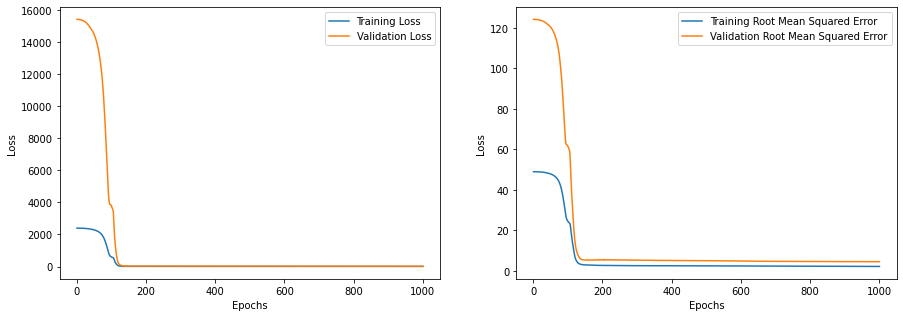

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [25]:
AAPL_prediction = AAPL_Model.predict(AAPL_Test_X) # predicting using the created model

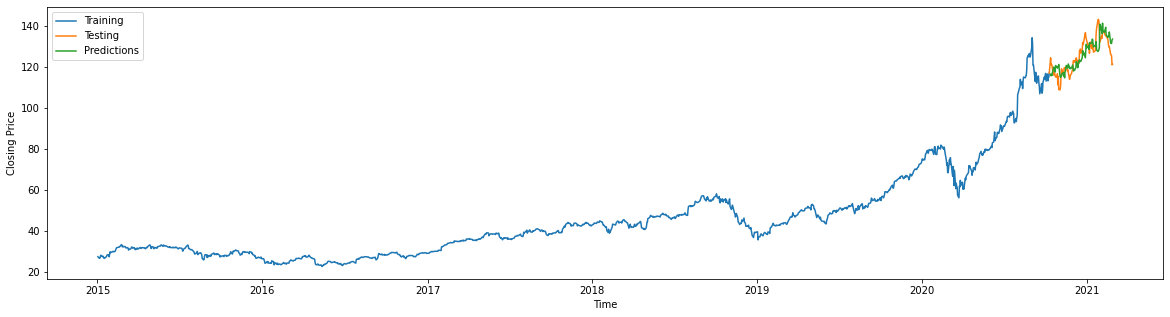

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(AAPL['Date'][AAPL['Date'] < '2020-10-12'], AAPL['Close'][AAPL['Date'] < '2020-10-12'], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-09'], AAPL['Close'][AAPL['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-12'], AAPL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')
#Plotting the prediction 

### Printing the RMSE

In [27]:
rmse = math.sqrt(mean_squared_error(AAPL_Test_Y.reshape(-1, 5), AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Test_Y.reshape(-1, 5))/np.abs(AAPL_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 4.475322389861471
MAPE: 0.027077216873668528


In [31]:
AAPL_Model.save('model/prediction')

INFO:tensorflow:Assets written to: model/prediction\assets
